In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split

## Open MNIST data and create a subset with desired digits
MNIST dataset contains 70,000 images of hand-written digits from 0 to 9. Each image has a grey-scale resolution of 28 $\times$ 28 (i.e., 784 pixels). Each pixel has an integer value ranging from 0 (bright) to 255 (dark).

<font color=red>Change the code below to select a different subset </font>

In [3]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

# Change the conditions below to compare between other two digits.
class1Indices = (y==0)
class2Indices = (y==1)

x1 = X[class1Indices]
x2 = X[class2Indices]

Xtrain = np.concatenate((x1,x2),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0])),axis=0)


#ytrain = ytrain.reshape(-1,1)
# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
print("xtrain: ",Xtrain.shape)
print("ytrain: ",ytrain.shape)
print("x1 " , x1.shape )
print("x2 " , x2.shape )

xtrain:  (14780, 784)
ytrain:  (14780,)
x1  (6903, 784)
x2  (7877, 784)


# 1. Split the data to training, testing, and validation subsets

In [5]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)
    
# Split the data to training, testing, and validation subsets
    
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) # 0.25 x 0.8 = 0.2


Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]


# 2. Accuracy of a classifier

In [24]:
def testLinearClassifier(a,X,y):
    # YOUR CODE HERE
    #a = np.concatenate([w.T, np.array([w_0])])
    X = np.column_stack((X, np.ones((X.shape[0],1))))
    #print("Shape_X: ", X.shape)
    discriminants = np.dot(X,a)
    predictions = discriminants >0
    misclassifications  = np.sum(predictions != y)
    return (misclassifications)


## 3. Define and test gaussianClassifierWithIdentityCovariance 

Mis-classifications= 5524 out of  10346  equivalent to  53.39261550357626%
Mis-classifications= 777 out of  1478  equivalent to  52.57104194857916%
Mis-classifications= 1576 out of  2956  equivalent to  53.31529093369418%


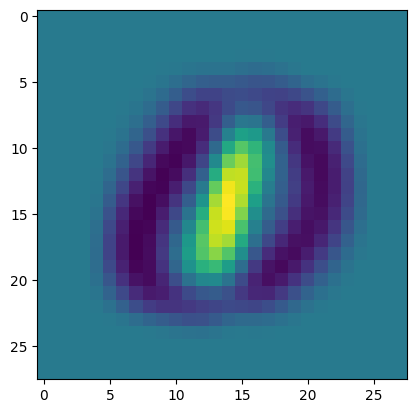

In [25]:
#------TRAINING CODE --------------

def gaussianClassifierWithIdentityCovariance(Xtrain,ytrain):
    #print(Xtrain.shape)
    mu1 = np.mean(Xtrain[ytrain == 0], axis =0)
    mu2 = np.mean(Xtrain[ytrain == 1],axis = 0)
    w = mu2 - mu1
    w_0 = np.dot(w.T, ((mu1+mu2)/2)) 
    a = np.concatenate([w.T, np.array([w_0])])
    #print("shape a: ", a.shape)
    #a1 = np.dot(X,a)
    return a
    #YOUR CODE HERE


#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithIdentityCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)

print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(train, int(X_train.shape[0]),train *100 / int(X_train.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(val, int(X_val.shape[0]),val*100 / int(X_val.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(test, int(X_test.shape[0]),test*100 / int(X_test.shape[0])))


## 4. Define and test gaussianClassifierWithCommonCovariance 

Mis-classifications= 48 out of  10346  equivalent to  0.4639474192924802%
Mis-classifications= 19 out of  1478  equivalent to  1.2855209742895806%
Mis-classifications= 22 out of  2956  equivalent to  0.7442489851150202%


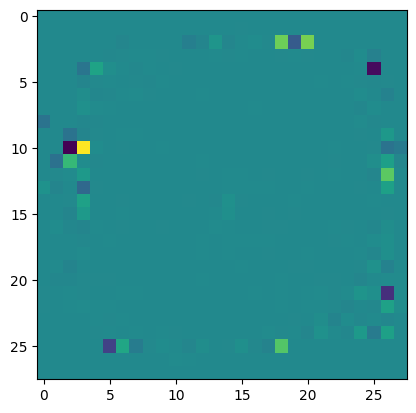

In [27]:
#------TRAINING CODE --------------

def gaussianClassifierWithCommonCovariance(Xtrain,ytrain):
    mu1 = np.mean(Xtrain[ytrain == 0], axis =0)
    mu2 = np.mean(Xtrain[ytrain == 1],axis = 0)
    #print("mu1:", mu1)
    #print("mu2:", mu2)
    x1 = Xtrain[ytrain == 0]
    x2 = Xtrain[ytrain == 1]
    #Number of sample x1 and x2
    N1 = x1.shape[0]
    N2 = x2.shape[0]
    #print("Shape1 :",(x1-mu1).shape)
    #print("Shape2:", x2.shape)
    #Covariance matrix
    Sigma = (1/(N1+N2))*(np.dot((x1-mu1).T,(x1-mu1))+np.dot((x2-mu2).T,(x2-mu2)))
    for i in range(Sigma.shape[0]):
        Sigma[i, i] += 1e-6
    Sigma_inverse = np.linalg.inv(Sigma)
    w = np.dot(Sigma_inverse, (mu2 - mu1).T)
    w_0 = -np.dot(np.dot(Sigma_inverse, (mu2 - mu1).T), ((mu1+mu2)/2)) + np.log(N2/N1)
    #w_0 = 0.5 * (np.dot(np.dot(mu2.T, Sigma_inverse),mu2) -  np.dot(np.dot(mu1.T, Sigma_inverse),mu1)) #+ np.log(N1/N2)
    a2 = np.concatenate([w, np.array([w_0])])
    #print("Complete your code")
    #print("Shape Sigma: ", w_0.shape)
    #print("Shape w: ", w.shape)
    return a2
    #YOUR CODE HERE

    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithCommonCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(train, int(X_train.shape[0]),train*100 / int(X_train.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(val, int(X_val.shape[0]),val*100 / int(X_val.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(test, int(X_test.shape[0]),test*100 / int(X_test.shape[0])))


Result validation\
Complete your code\
Mis-classifications= 6318.0 out of  8897 equivalent to 71.01270091041924 % \
Mis-classifications= 1034.0 out of  1449 equivalent to 71.35955831608005 %  \
Mis-classifications= 3135.0 out of  4434 equivalent to 70.70365358592693 %\

## 5. Define and test logisticRegression 

You may choose the step size as 1e-4. You can try changing it.

Use the expit() function from scipy.special.expit to implement sigmoid without overflow errors 

(10346, 784)
Mis-classifications= 10 out of  10346  equivalent to  0.09665571235260004%
Mis-classifications= 2 out of  1478  equivalent to  0.13531799729364005%
Mis-classifications= 4 out of  2956  equivalent to  0.13531799729364005%


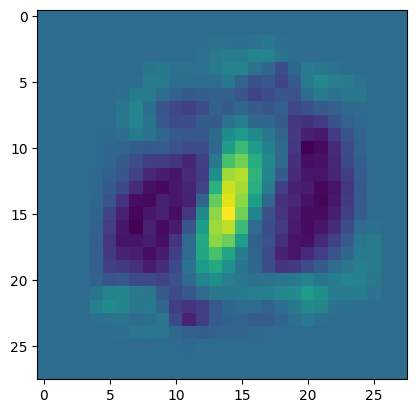

In [38]:
from scipy.special import expit

def logisticRegression(Xtrain,ytrain,iterations=100,step_size=1e-4,verbose=True):
    a3 = 0.01*np.random.randn(Nfeatures+1,)
    # mu1 = np.mean(Xtrain[ytrain == 0], axis =0)
    # mu2 = np.mean(Xtrain[ytrain == 1],axis = 0)
    # w = mu2 - mu1
    # w_0 = np.dot(w.T, ((mu1+mu2)/2)) 
    # a3 = np.concatenate([w.T, np.array([w_0])])
    #print("Shape: ", a3.shape)
    
    Xtrain = np.column_stack((Xtrain, np.ones((Xtrain.shape[0],1))))
    epsilon = 1e-6
    for i in range (iterations):
        #predictions = 1/(1+np.exp(-(np.dot(Xtrain,a3))))
        predictions = expit(np.dot(Xtrain,a3))
        gradient = -np.dot(Xtrain.T, (predictions - ytrain)) 
        a3 += step_size *gradient
        #print("gradient :", gradient)
        #print("a :", a3)
        if verbose:
            cost = -np.mean(ytrain * np.log(predictions+epsilon) + (1 - ytrain) * np.log(1 - predictions+epsilon))
            #print("The cost = {}".format(cost))
    #a = 0.01*np.random.randn(Nfeatures+1,1)
    #print("Complete your code")
    
    return a3
    #YOUR CODE HERE
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegression(X_train,y_train,iterations=500,verbose=False)
plt.imshow(np.reshape(a[0:784],(28,28)))

print(X_train.shape)
train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)

print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(train, int(X_train.shape[0]),train*100 / int(X_train.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(val, int(X_val.shape[0]),val*100 / int(X_val.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(test, int(X_test.shape[0]),test*100 / int(X_test.shape[0])))


## 6. Define and test logisticRegression with regularization

Complete your code\
Mis-classifications= 5607.0 out of  8897 equivalent to 63.021243115656965 %\
Mis-classifications= 918.0 out of  1449 equivalent to 63.35403726708075 %\
Mis-classifications= 2845.0 out of  4434 equivalent to 64.16328371673433 %\

Mis-classifications= 30 out of  10346  equivalent to  0.28996713705780014%
Mis-classifications= 3 out of  1478  equivalent to  0.2029769959404601%
Mis-classifications= 11 out of  2956  equivalent to  0.3721244925575101%


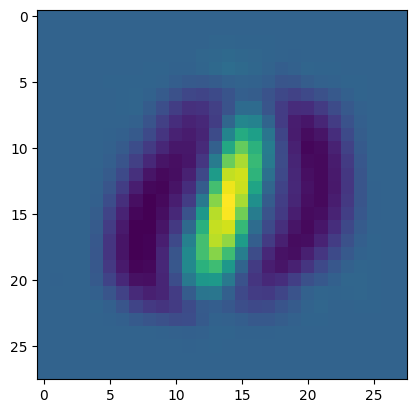

In [39]:
mu1 = np.mean(Xtrain[ytrain == 0], axis =0)
mu2 = np.mean(Xtrain[ytrain == 1],axis = 0)
w = mu2 - mu1
w_0 = np.dot(w.T, ((mu1+mu2)/2)) 

def logisticRegressionWithRegularization(Xtrain,ytrain,iterations=100,step_size=1e-4,lam=0,verbose=True):
    a = 0.01*np.random.randn(Nfeatures+1,)
    #a = np.concatenate([w.T, np.array([w_0])])
    epsilon = 1e-6
    Xtrain = np.column_stack((Xtrain, np.ones((Xtrain.shape[0],1))))
    for i in range (iterations):
        predictions = expit(np.dot(Xtrain,a))
        gradient = -np.dot(Xtrain.T, (predictions - ytrain)) + 2 * lam * a
        #gradient = -np.dot(Xtrain.T, (predictions - ytrain))
           # Update weights and bias separately
        a += step_size *gradient
        if verbose and i % 100 == 0:
            cost = -np.mean(ytrain * np.log(predictions+epsilon) + (1 - ytrain) * np.log(1 - predictions+epsilon)) + lam * np.sum(a[:-1] ** 2)
            #print("Cost :",cost)
    #a = 0.01*np.random.randn(Nfeatures+1,1)
    #print("Complete your code")
    
    return a
    #YOUR CODE HERE
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
#a = logisticRegressionWithRegularization(X_train,y_train,iterations=500,verbose=False,lam=10)
a = logisticRegressionWithRegularization(X_train,y_train,iterations=500,step_size=1e-4,lam=100,verbose=True)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(train, int(X_train.shape[0]),train*100 / int(X_train.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(val, int(X_val.shape[0]),val*100 / int(X_val.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(test, int(X_test.shape[0]),test*100 / int(X_test.shape[0])))



Best lam:  0.01
Mis-classifications= 6 out of  10346  equivalent to  0.05799342741156002%
Mis-classifications= 2 out of  1478  equivalent to  0.13531799729364005%
Mis-classifications= 4 out of  2956  equivalent to  0.13531799729364005%


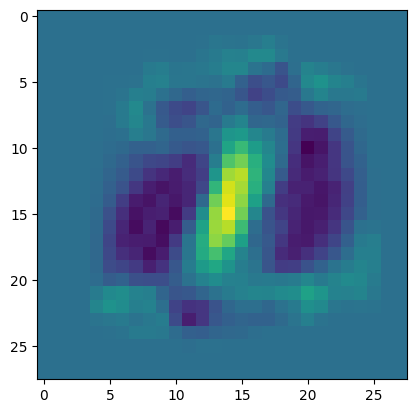

In [40]:
def optimizeHyperparameters(Xtrain,ytrain):
    lambda_values = [0.01, 0.1, 1, 10, 100]
    #lambda_values = np.linspace(0.01, 100, 100)
    lamopt = None
    lowest_error = float('inf')
        # YOUR CODE HERE
    for lam in lambda_values:
        a = logisticRegressionWithRegularization(Xtrain,ytrain,iterations=100,step_size=1e-4,lam=lam,verbose=False)
        error = testLinearClassifier(a, X_val, y_val)
        #print("Error: ", error)
        if error < lowest_error:
            lowest_error = error
            lamopt = lam
    print("Best lam: ",lamopt)
    return lamopt

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
#a = logisticRegressionWithRegularization(X_train,y_train,iterations=500,verbose=False,lam=10)
a = logisticRegressionWithRegularization(X_train,y_train,iterations=500,step_size=1e-4,lam=optimizeHyperparameters(Xtrain,ytrain),verbose=True)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(train, int(X_train.shape[0]),train*100 / int(X_train.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(val, int(X_val.shape[0]),val*100 / int(X_val.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(test, int(X_test.shape[0]),test*100 / int(X_test.shape[0])))



# REPORT TEST ERRORS OF THE BEST MODELS

YOUR CODE BELOW

In [43]:
a1 = gaussianClassifierWithIdentityCovariance(X_train, y_train)
a2 = gaussianClassifierWithCommonCovariance(X_train, y_train)
a3 = logisticRegression(X_train, y_train)
lamopt = optimizeHyperparameters(X_train, y_train)
a4 = logisticRegressionWithRegularization(X_train, y_train, lam=lamopt)


misclassifications_a1 = testLinearClassifier(a1, X_test, y_test)
misclassifications_a2 = testLinearClassifier(a2, X_test, y_test)
misclassifications_a3 = testLinearClassifier(a3, X_test, y_test)
misclassifications_a4 = testLinearClassifier(a4, X_test, y_test)

# Report the results
print(f"Number of misclassifications with Gaussian Classifier (Identity Covariance): {misclassifications_a1}")
print(f"Number of misclassifications with Gaussian Classifier (Common Covariance): {misclassifications_a2}")
print(f"Number of misclassifications with Logistic Regression: {misclassifications_a3}")
print(f"Number of misclassifications with Logistic Regression (Regularization, λ={lamopt}): {misclassifications_a4}")



Best lam:  0.01
Number of misclassifications with Gaussian Classifier (Identity Covariance): 1576
Number of misclassifications with Gaussian Classifier (Common Covariance): 22
Number of misclassifications with Logistic Regression: 9
Number of misclassifications with Logistic Regression (Regularization, λ=0.01): 7


The Gaussian with identity variance obtained the highest misclassification (1576) becuase the model assumes that features are indepdent, which is unrealistic a assumption. A high misclassificaions suggests that the model is not a good model. When including the covariance in the model and assuming that all classes share the same covariance mareix, the misclassification number significantly lower to 22. Logistic regression without regularization results in 9 misclassifications, which is a good outcome and suggests that the linear decision boundary formed by logistic regression is well-suited for the dataset. The performance with regularization is better than the model without regularization indicates that the model benefits from controlling for overfitting. Testing with sklearn also provides the same misclassification number (9).

In [13]:
#Testing with skitlearn
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression( max_iter=100, penalty='l2', random_state=None, 
          verbose=True, warm_start=False)
logisticRegr.fit(X_train,y_train)
sklearn_pred = logisticRegr.predict(X_test)
misclassification = np.sum(sklearn_pred != y_test)
print("Misclassification :", misclassification)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.17130D+03    |proj g|=  6.70004D+05

At iterate   50    f=  5.43113D-03    |proj g|=  1.47601D-02

At iterate  100    f=  4.71040D-03    |proj g|=  2.03291D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    115      1     0     0   2.033D-04   4.710D-03
  F =   4.7104015142464158E-003

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Misclassification : 9


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
